In [1]:
from DataProcessor import DataProcessor

# read in combined stock data
preprocessor = DataProcessor()

# create df to current date
data = preprocessor.process_nrw_data("06_08")


File already exists: processed_nrw_data/06_08_nrw_stock_data.csv. Loading DataFrame from file.


G:\My Drive\Master IS\Repos\webscraper\data_analysis\DataProcessor.py:140: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["store_availabilityInfo"] = df["store_availabilityInfo"].fillna(False)


C:\Users\felix\AppData\Local\Temp\ipykernel_5484\3858416344.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  available_variants = available_variants.groupby('sub_category').head(3)


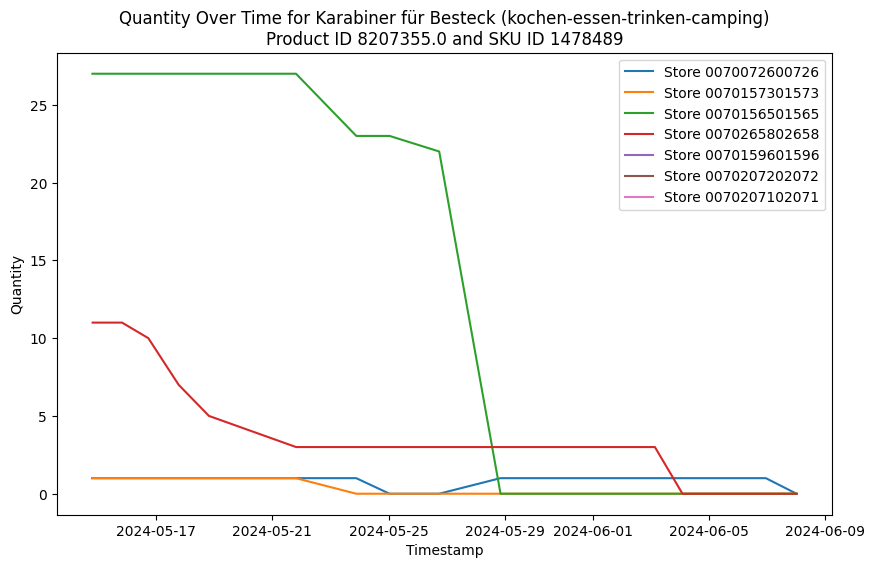

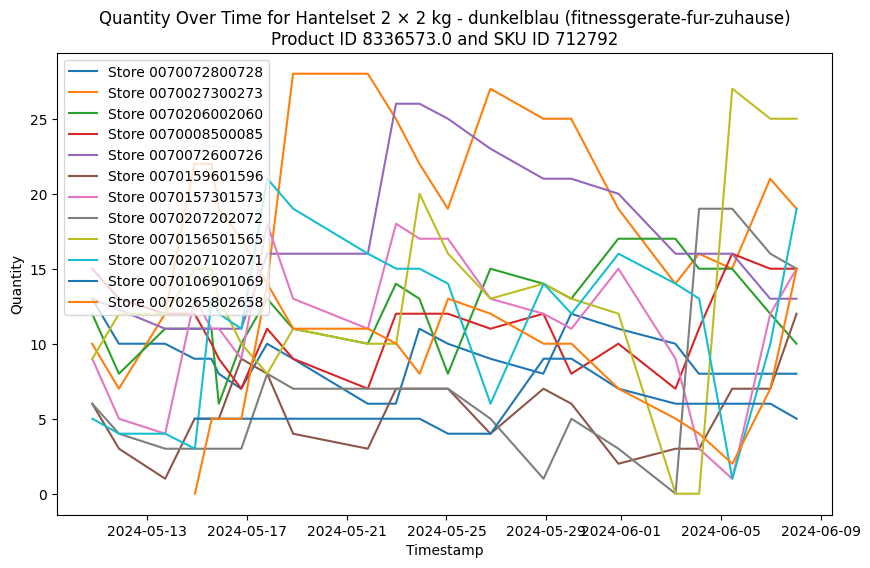

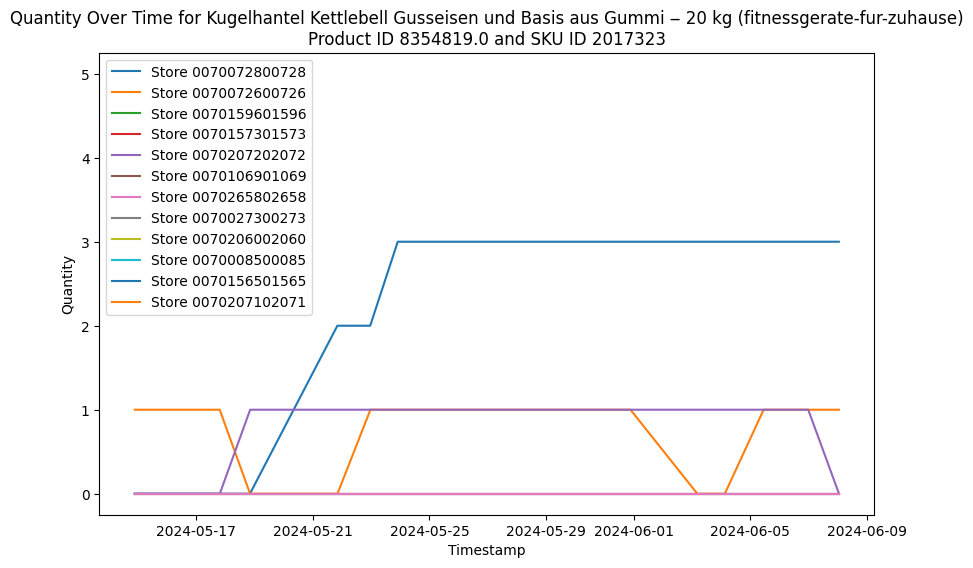

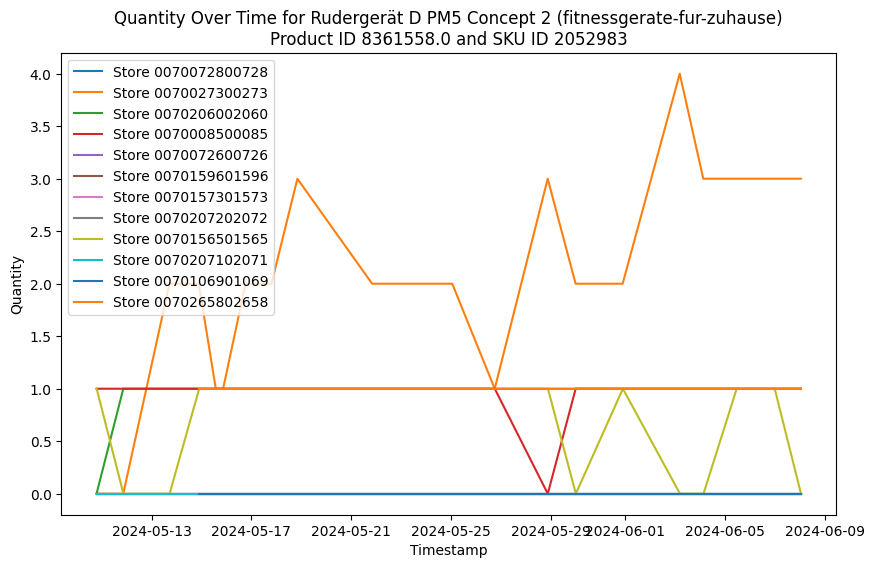

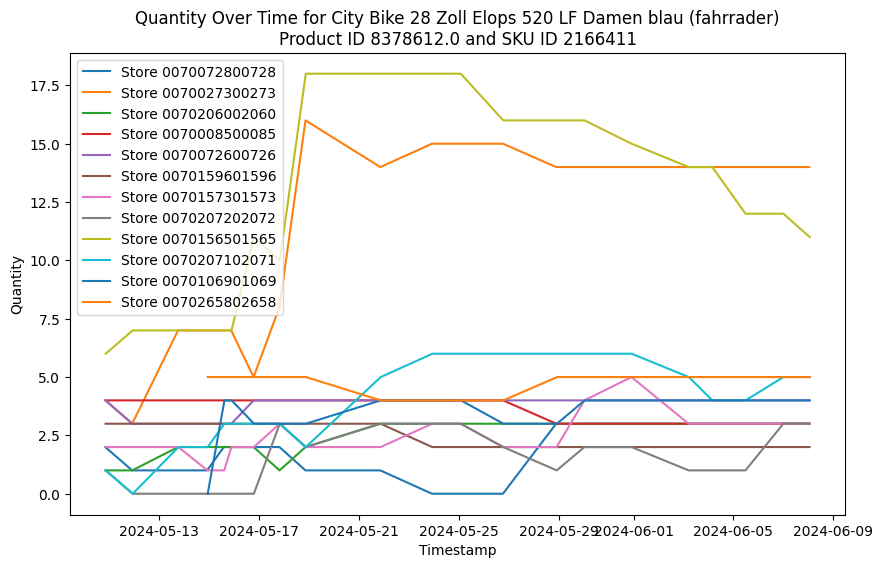

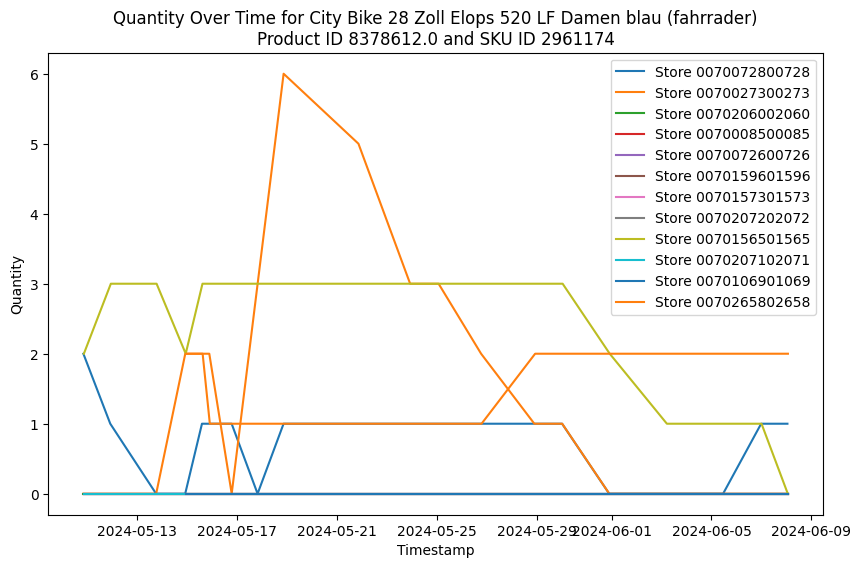

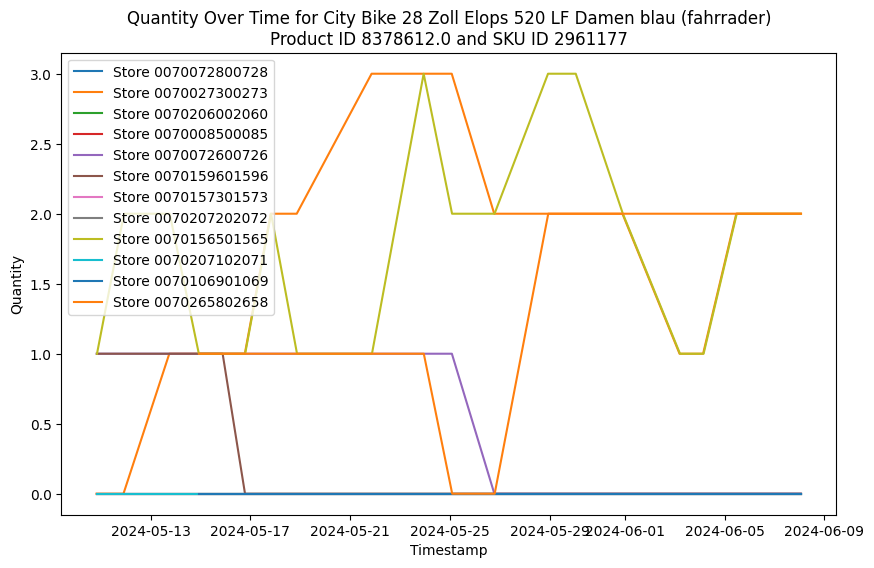

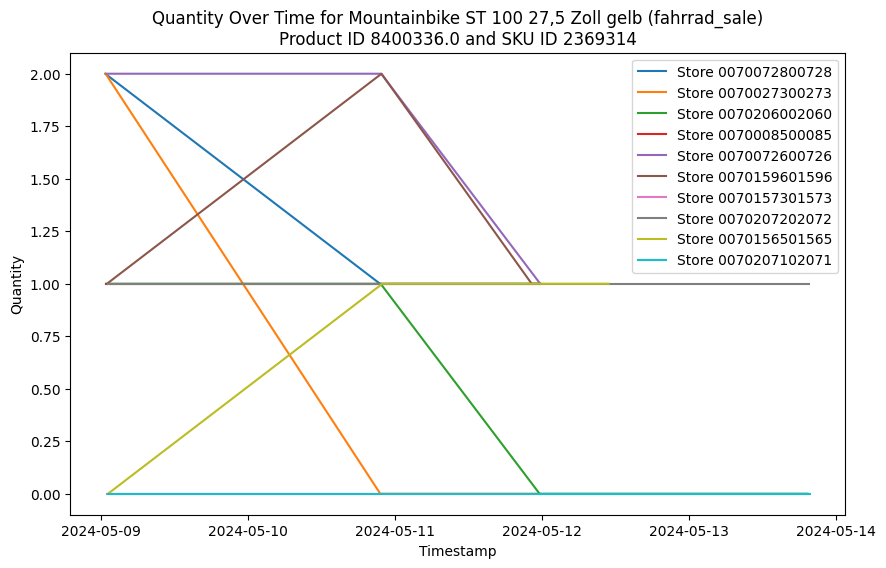

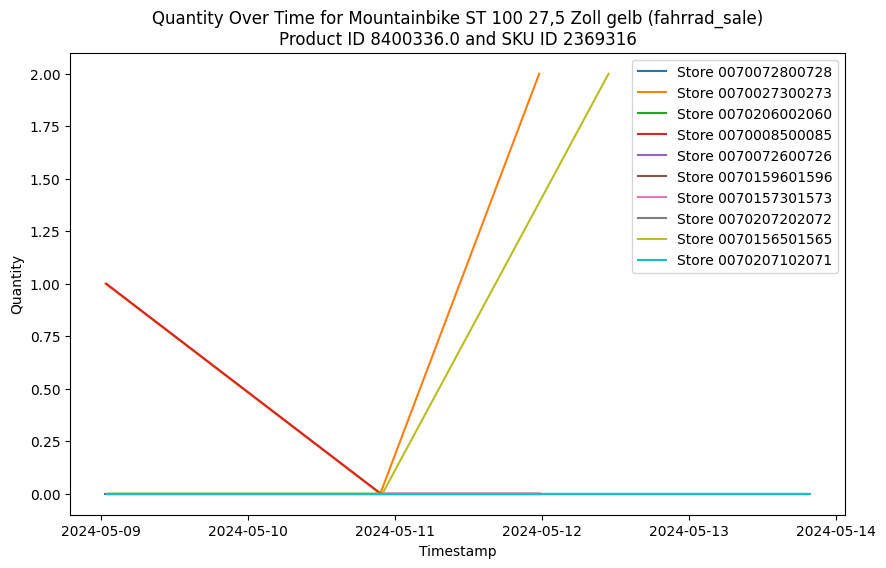

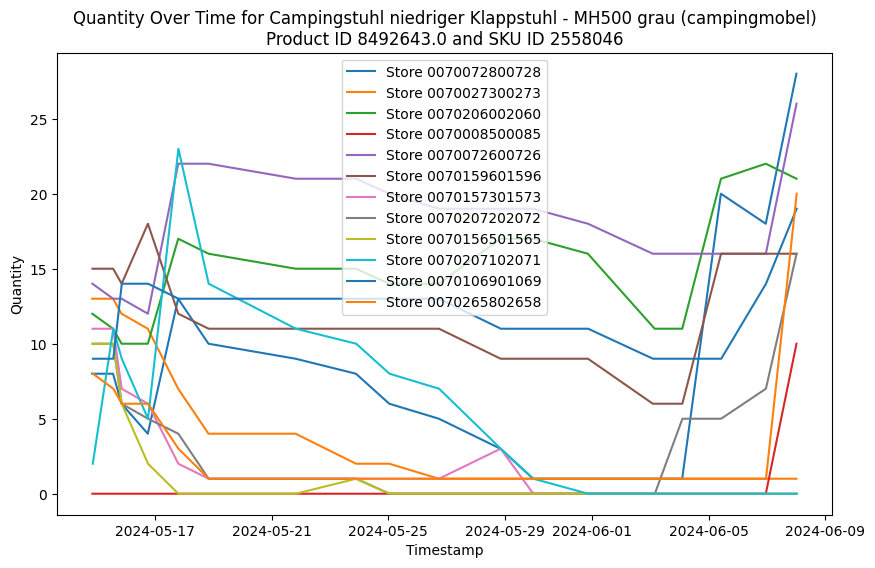

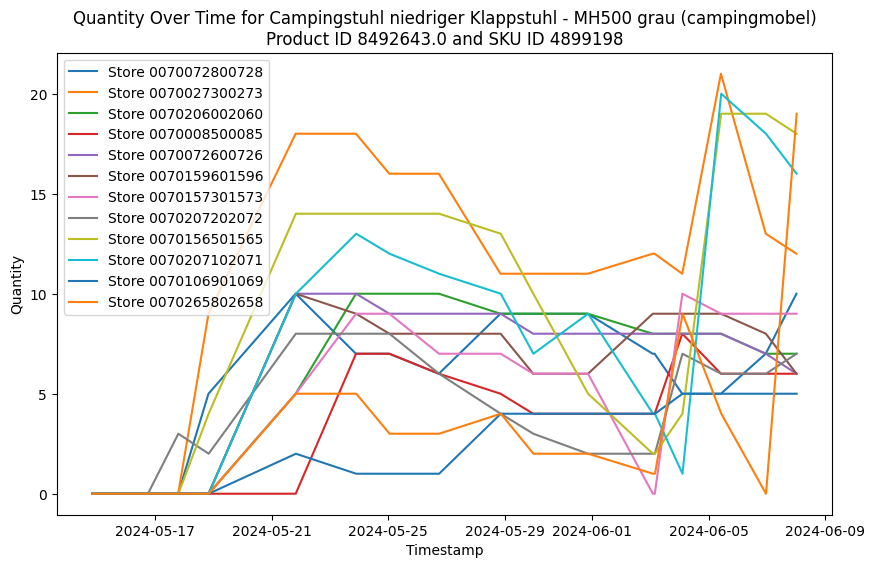

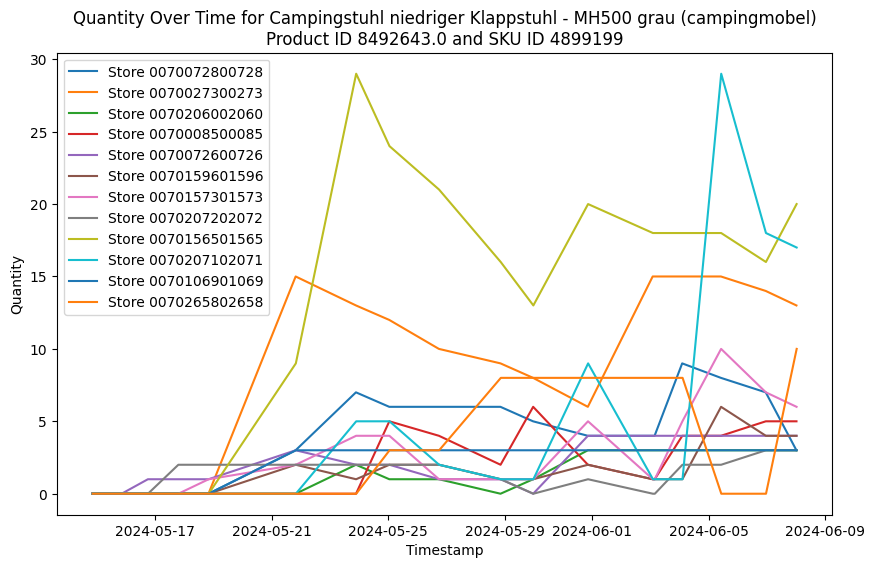

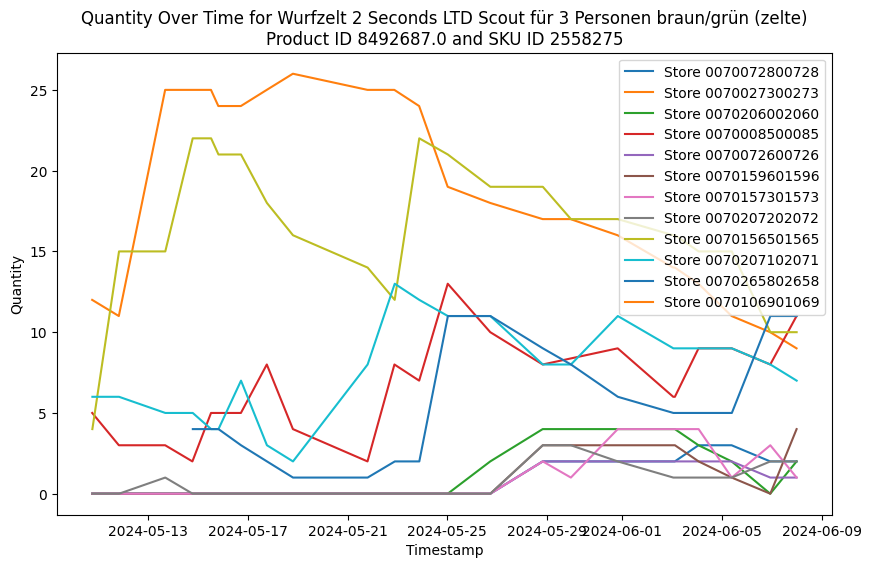

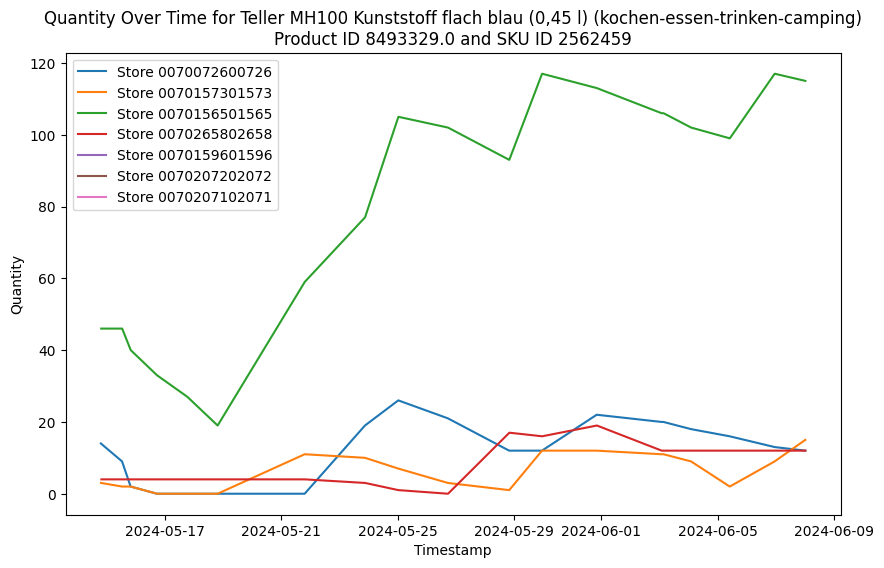

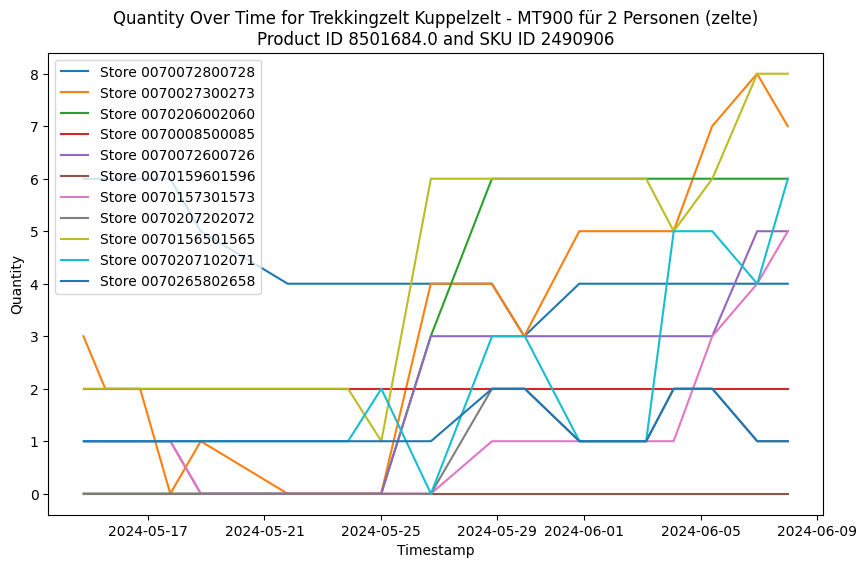

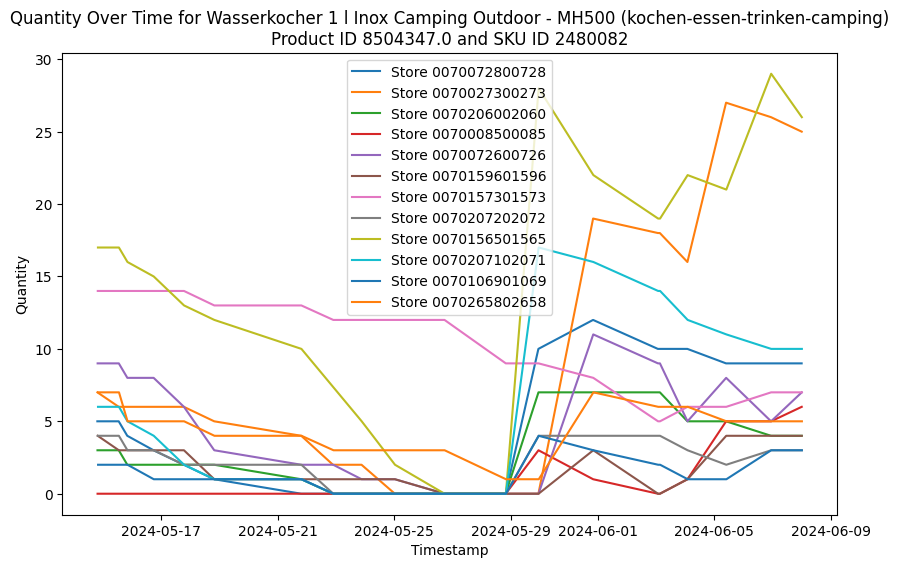

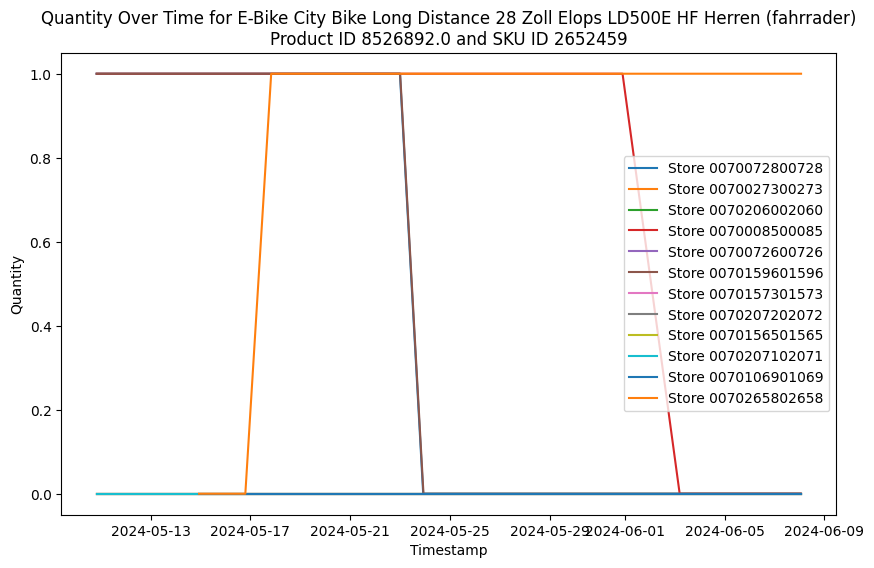

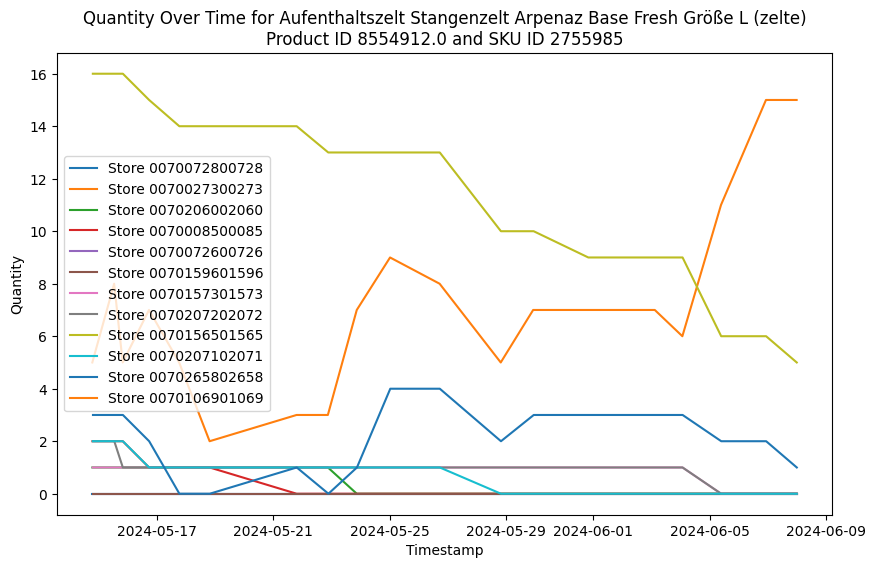

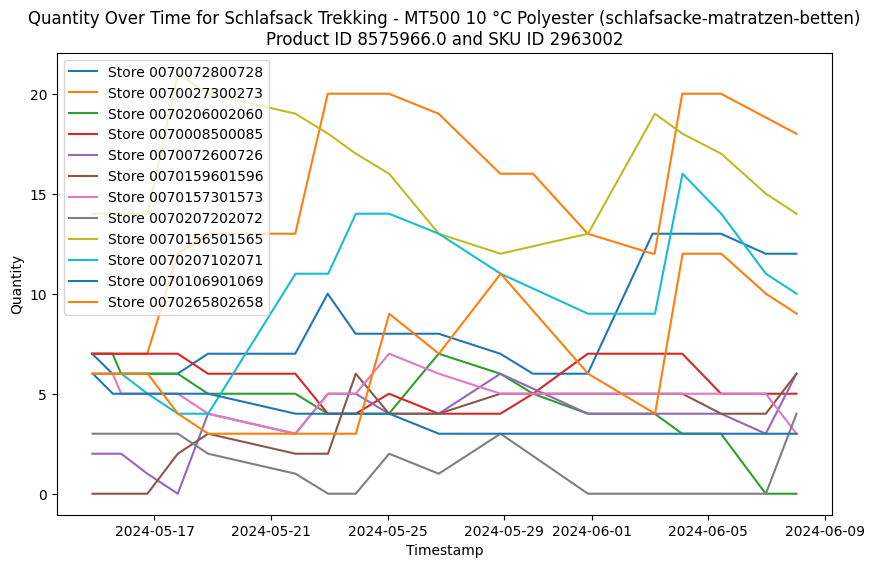

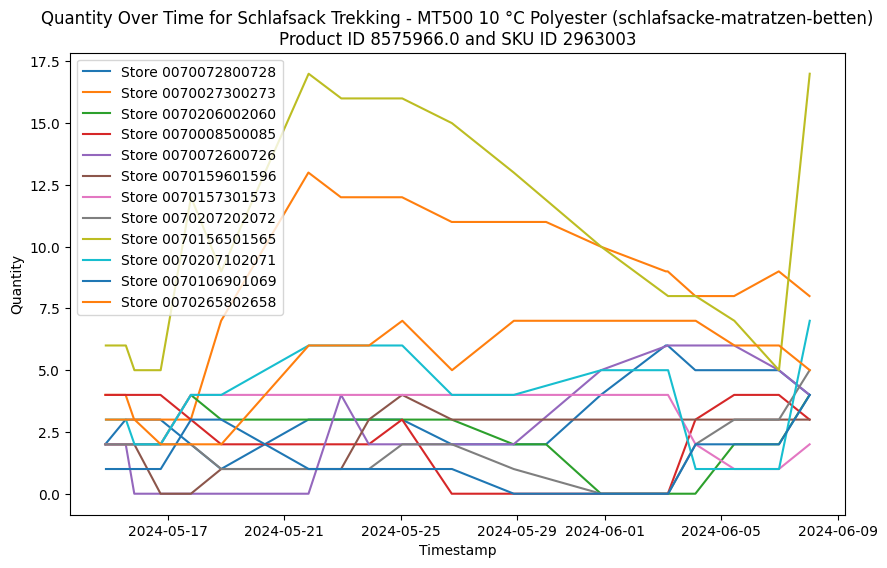

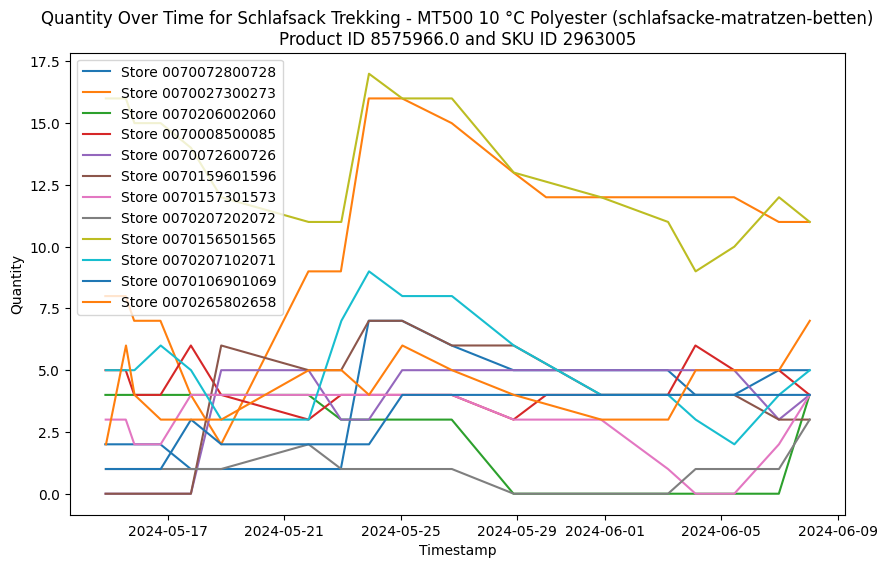

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `data` is already loaded into a DataFrame
# data = preprocessor.process_nrw_data("06_08")

# Step 1: Ensure proper data types
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['id'] = data['id'].astype(str)
data['store_skuId'] = data['store_skuId'].astype(str)
data['store_storeId'] = data['store_storeId'].astype(str)

# Step 2: Identify product variants in at least 5 different stores
store_count = data.groupby(['id', 'store_skuId'])['store_storeId'].nunique().reset_index()
store_count = store_count[store_count['store_storeId'] >= 5]

# Step 3: Filter by availability and stock-out
filtered_data = data[(data['id'].isin(store_count['id'])) & (data['store_skuId'].isin(store_count['store_skuId']))]

availability_check = filtered_data.groupby(['id', 'store_skuId', 'store_storeId']).agg({
    'store_quantity': ['max', 'min']
}).reset_index()
availability_check.columns = ['id', 'store_skuId', 'store_storeId', 'max_quantity', 'min_quantity']

# Find variants that became sold out in at least 3 stores over time
sold_out_variants = availability_check[(availability_check['max_quantity'] > 0) & (availability_check['min_quantity'] == 0)]
sold_out_counts = sold_out_variants.groupby(['id', 'store_skuId']).size().reset_index(name='sold_out_count')
sold_out_counts = sold_out_counts[sold_out_counts['sold_out_count'] >= 3]

# Check if the product variant is still available in some other stores
def check_still_available(variant_id, variant_skuId):
    variant_data = filtered_data[(filtered_data['id'] == variant_id) & (filtered_data['store_skuId'] == variant_skuId)]
    last_available_store = variant_data.groupby('store_storeId')['timestamp'].max().reset_index()
    still_available = variant_data[variant_data['store_quantity'] > 0].drop_duplicates(subset=['store_storeId'])
    return len(still_available) > 0

available_variants = sold_out_counts.apply(lambda row: check_still_available(row['id'], row['store_skuId']), axis=1)
available_variants = sold_out_counts[available_variants]

# Step 4: Plotting stock quantity over time
def plot_quantity_over_time(variant_id, variant_skuId):
    variant_data = data[(data['id'] == variant_id) & (data['store_skuId'] == variant_skuId)]
    product_name = variant_data['product_name'].iloc[0]
    sub_category = variant_data['sub_category'].iloc[0]
    
    plt.figure(figsize=(10, 6))
    for store_id in variant_data['store_storeId'].unique():
        store_data = variant_data[variant_data['store_storeId'] == store_id]
        plt.plot(store_data['timestamp'], store_data['store_quantity'], label=f'Store {store_id}')
    
    plt.title(f'Quantity Over Time for {product_name} ({sub_category})\nProduct ID {variant_id} and SKU ID {variant_skuId}')
    plt.xlabel('Timestamp')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

# Limit to max 3 variants per sub category for plotting
available_variants = available_variants.merge(data[['id', 'store_skuId', 'sub_category']].drop_duplicates(), on=['id', 'store_skuId'])
available_variants = available_variants.groupby('sub_category').head(3)

# Plot each variant
for _, row in available_variants.iterrows():
    plot_quantity_over_time(row['id'], row['store_skuId'])
